In [1]:
import cv2
import numpy as np
from scipy.signal import convolve
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

In [2]:
def myFlow(img1, img2, window_length, tau):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

    derivative_filter = np.array([-1, 8, 0, -8, 1]) / 12
    Ix = convolve(gray1, derivative_filter[np.newaxis])
    Iy = convolve(gray1, derivative_filter[np.newaxis].T)

    blurred1 = gaussian_filter(gray1, sigma=1)
    blurred2 = gaussian_filter(gray2, sigma=1)
    It = blurred2 - blurred1

    u = np.zeros_like(gray1)
    v = np.zeros_like(gray1)
    v_flow = np.zeros_like(gray1, dtype=bool)

    w = window_length // 2

    for y in range(w, gray1.shape[0] - w):
        for x in range(w, gray1.shape[1] - w):
            Ix_window = Ix[y - w:y + w + 1, x - w:x + w+ 1]
            Iy_window = Iy[y - w:y + w + 1, x - w:x + w + 1]
            It_window = It[y - w:y + w + 1, x - w:x + w + 1]

            A = np.vstack((Ix_window.flatten(), Iy_window.flatten())).T
            b = -It_window.flatten()

            if np.linalg.det(A.T @ A) < tau:
                continue

            uv = np.linalg.inv(A.T @ A) @ A.T @ b
            u[x, y], v[x, y] = uv
            v_flow[y, x] = True

    return u, v, v_flow

In [3]:
def harris_corner_detection(img, block_size=2, ksize=3, k=0.04, threshold=0.01):
    if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
    gray = np.float32(gray)
    response = cv2.cornerHarris(gray, blockSize=block_size, ksize=ksize, k=k)
    response = cv2.normalize(response, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    corners = []
    for i in range(block_size//2, img.shape[0]-block_size//2):
        for j in range(block_size//2, img.shape[1]-block_size//2):
            if np.all(response[i, j] > threshold):
                if np.all(response[i, j] >= response[i-block_size//2:i+block_size//2+1, j-block_size//2:j+block_size//2+1]):
                    corners.append((j, i))

    return corners


In [8]:
def track_keypoints(image_sequence, keypoints, window_size=15):
    tracked_keypoints = [keypoints]

    lk_params = dict(winSize=(window_size, window_size),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    prev_pts = np.array(keypoints, dtype=np.float32).reshape(-1, 1, 2)

    for idx in range(1, len(image_sequence)):
        prev_img = image_sequence[idx-1]
        curr_img = image_sequence[idx]

        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, curr_img, prev_pts, None, **lk_params)

        tracked_pts = next_pts[status == 1].reshape(-1, 2)
        tracked_keypoints.append(tracked_pts.tolist())

        prev_pts = tracked_pts.reshape(-1, 1, 2)

    return tracked_keypoints

In [9]:
def display_tracked_keypoints(image_sequence, tracked_keypoints):
    for idx, img in enumerate(image_sequence):
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {idx}")

        for i in range(len(tracked_keypoints[0]) - 1):
            xs = [kp[i][0] for kp in tracked_keypoints[:idx+1]]
            ys = [kp[i][1] for kp in tracked_keypoints[:idx+1]]
            plt.plot(xs, ys, 'o-', markersize=2, linewidth=1)

        plt.axis('off')
    plt.show()


C:\Users\mp246\AppData\Local\Temp\ipykernel_9024\1964955143.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


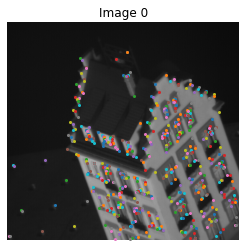

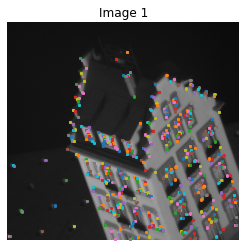

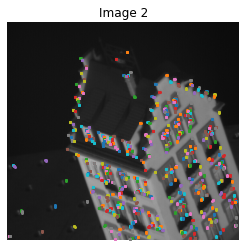

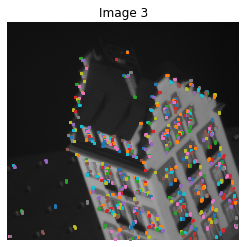

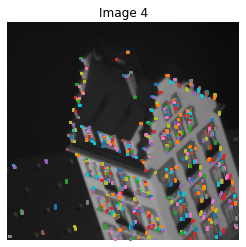

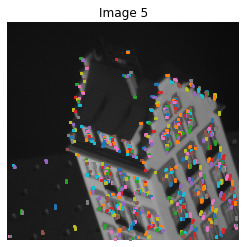

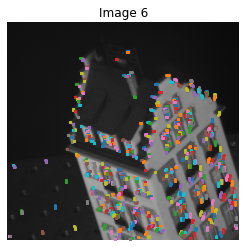

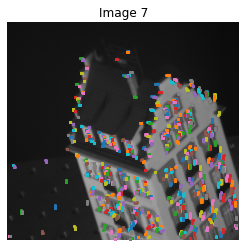

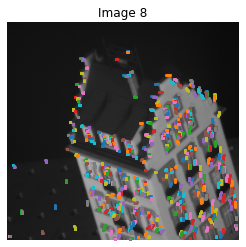

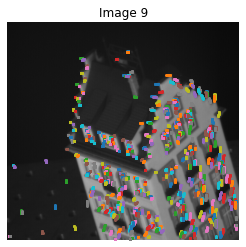

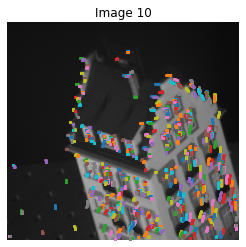

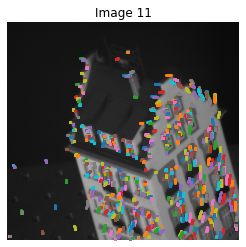

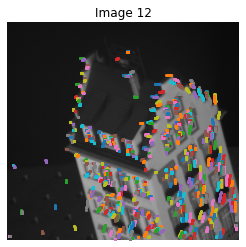

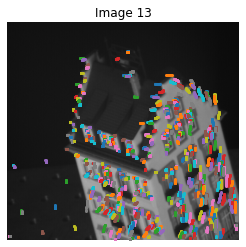

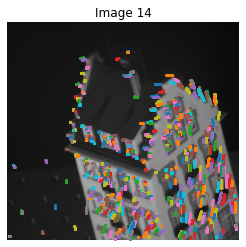

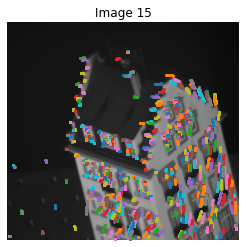

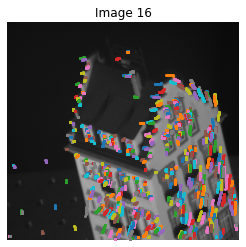

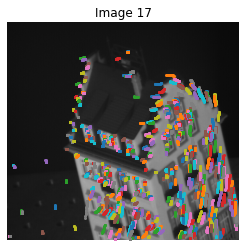

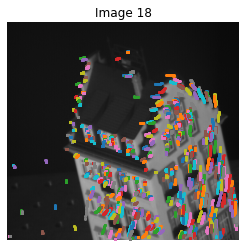

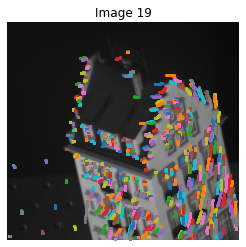

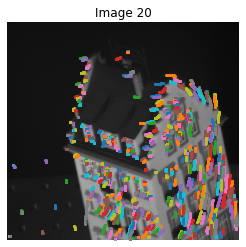

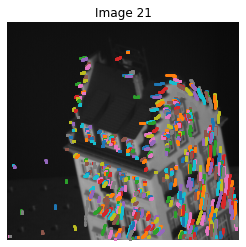

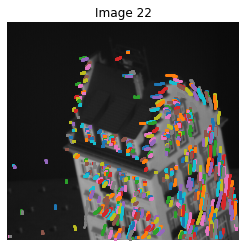

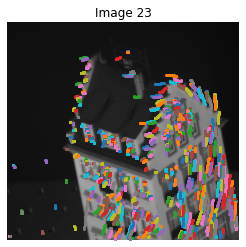

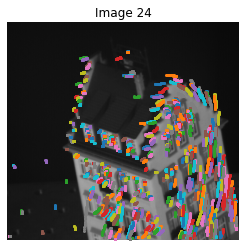

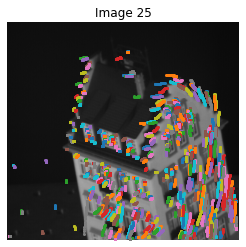

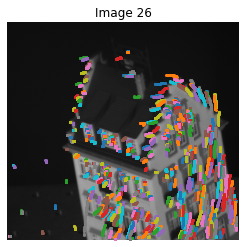

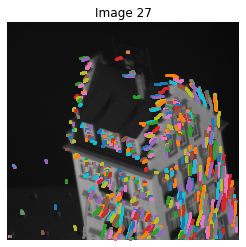

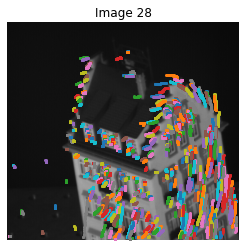

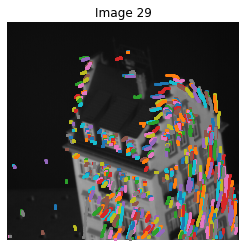

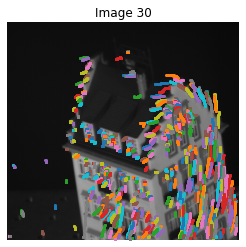

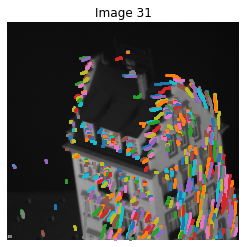

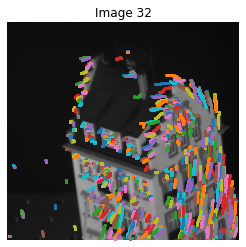

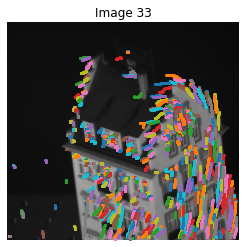

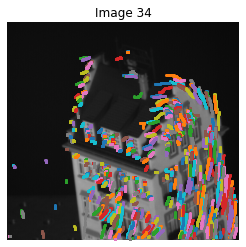

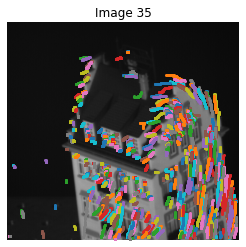

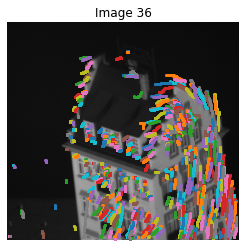

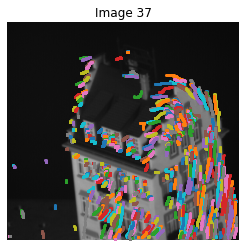

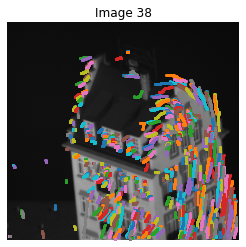

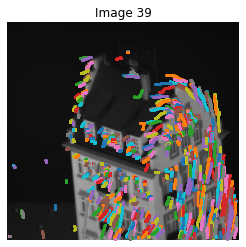

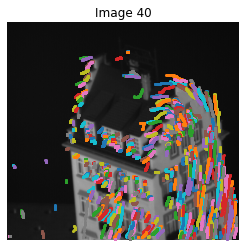

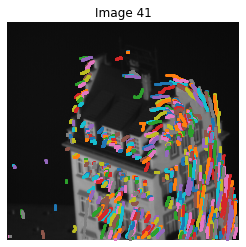

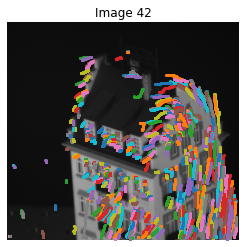

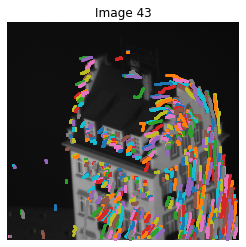

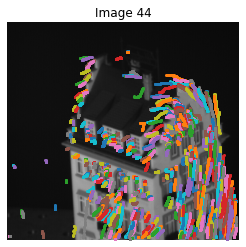

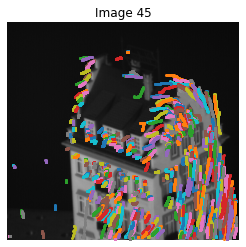

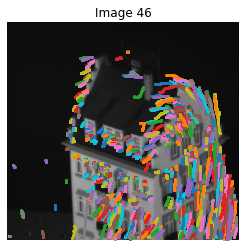

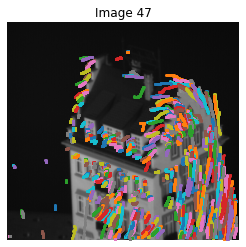

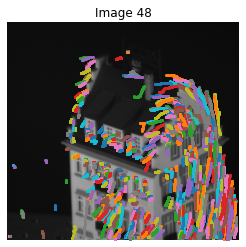

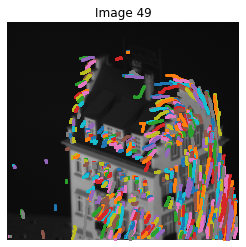

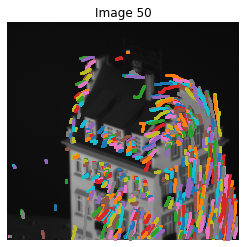

In [4]:
image_filenames = [f"hotel.seq{i}.png" for i in range(50+1)]
image_sequence = [cv2.imread(filename, 0) for filename in image_filenames]

keypoints = harris_corner_detection(image_sequence[0])
tracked_keypoints = track_keypoints(image_sequence, keypoints)

display_tracked_keypoints(image_sequence, tracked_keypoints)


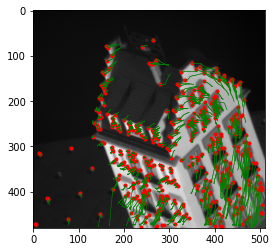

In [7]:
fig, ax = plt.subplots()
ax.imshow(image_sequence[0], cmap='gray')

for i in range(len(tracked_keypoints[0])):
    x, y = tracked_keypoints[0][i]
    ax.plot(x, y, 'ro', markersize=3)

for i in range(1, len(tracked_keypoints)):
    for j in range(len(tracked_keypoints[i-1])):
        x1, y1 = tracked_keypoints[i-1][j]
        x2, y2 = tracked_keypoints[i][j]
        ax.plot([x1, x2], [y1, y2], 'g-', linewidth=0.5)

plt.show()